In [12]:
from tools.game_tools import *
import matplotlib.pyplot as plt
%matplotlib inline

Inside the `game_tools.py` file, you can find the `Board()` class: one of its outputs is the game grid, created for the purpose of being able to play a game or observe its simulation. It also contains a bunch of vectors that are used to store all the useful information about the *board state*, such as the number of possible moves left, the number of valid moves and so on.\
All this information will later be used by the `Player()`'s children classes to make the decision about the next move.

The `Game()` object instantiates the game itself: the most important argument is the `game_type` argument, which selects the two participants in the game, whether human or algorithmic.

In [2]:
user_game_try = Game(game_type='user-user', verbose=True, player1='John', player2='Anna')

Game Type: user-user
Player #1: Anna, Human
Player #2: John, Human


In the cell below, you can challenge a friend in a classic game of *Connect4*.

In [3]:
user_game_try.play_game()

The WINNER is John, Human!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |     |  X  |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |     |  O  |  X  |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  O  |  X  |  O  |  X  |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  O  |  O  |  O  |  X  |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


By using the `save_game()` method, the whole game (sequence of the board states) is stored inside a Pandas Dataframe. As you can see, it is composed of 9 columns plus the index column, which just represents the turn number.\
\
Note that the *choice* column contains the player's choice on the board state represented along the same row, meaning that its effect on the board can be seen only in the following row.\
I decided to use this structure with the training of future ML models in mind: since the goal is for the model to produce a choice, we must imagine that it can only have data from the past to do so.\
Using as a feature a board state that has already been affected by a choice not yet made would be like looking into the future.

In [4]:
df = user_game_try.save_game()
df.head()

,player,choice,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,Anna,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,John,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,Anna,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,John,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,Anna,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


The `simulation()` function repeats the same process $n$ times. The goal is to simulate $n$ games played by autonomous systems.\
It also rearranges the indexing, so that each game has a unique index and the turn number as before, ending with 10 total columns.\
Note that the function avoids those games that end in a draw, since we are going to use only winning moves to train the algorithm.

In [5]:
# default save_json=False
dataset = simulation(n=100, game_type='random-random')

Simulating: 100%|███████████████| 100/100 [00:00<00:00, 146.69it/s]


In [6]:
dataset.head()

,player,choice,col_0,col_1,col_2,col_3,col_4,col_5,col_6,move
0,RandomAI_2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
0,RandomAI_1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1
0,RandomAI_2,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2
0,RandomAI_1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",3
0,RandomAI_2,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",4


Now let's explore the dataset a bit.\
For example, let's start with plotting the distribution of the moves number.

In [7]:
# getting a bigger pre-saved dataset
if len(dataset.index.unique()) < 10_000:
    dataset = read_json('simulations/simulation_random-random_10000.json')

In [8]:
# exactly n simulations, none of them ending in a draw
len(dataset.index.unique())

10000

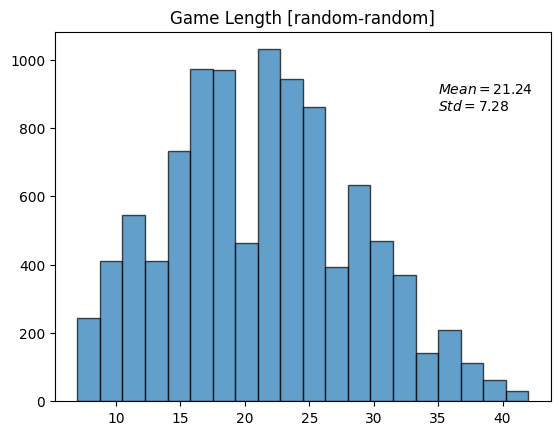

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42], dtype=int64)

In [9]:
row_count = dataset.groupby(level=0).size()

plt.hist(row_count, bins=20, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Game Length [random-random]')
plt.text(35, 900, f'$Mean = {row_count.mean().round(2)}$')
plt.text(35, 850, f'$Std = {row_count.std().round(2)}$')
plt.show()

np.sort(row_count.unique())

As expected, the absolute frequency follows a Gaussian distribution, with the minimum value being 7.\
\
We now check whether one player won more times than the other, and also whether being the initial player may have provided an advantage on the final outcome of the match.

In [10]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [11]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

RandomAI_1 winrate =  0.4992
RandomAI_2 winrate =  0.5008
Starter winrate  =  0.5603


The random players' winrates are basically identical, while it seems that starting the game first can give a certain advantage.\
\
Now you can try to play a game against this random-playing opponent, called *Randy*. The goal is to train a neural network that ultimately provides a much more stimulating level of challenge than *Randy*.\
\
*__Note__: when playing against any autonomous player, remember to set the arguments `pause=True` and `verbose=True`, otherwise the opponent's choice won't be displayed. Just press any key to display its choice during the game.*

In [12]:
play_game = Game(game_type='user-random', verbose=True, pause=True, player1='John', player2='Randy')

Game Type: user-random
Player #1: Randy, RandomAI
Player #2: John, Human


In [13]:
play_game.play_game()

The WINNER is John, Human!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |  O  |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |  X  |  O  |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  X  |  O  |  O  |     |     |     |  O  |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  O  |  X  |  X  |  X  |  X  |  O  |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


Now let's give a brief demonstration of the `SimplePlayer()` class, which implements the strategy described in the `player_tools.py` file inside the `tools` folder.

In [14]:
dataset = simulation(n=100, game_type='simple-random')
# getting a bigger pre-saved dataset
if len(dataset.index.unique()) < 10_000:
    dataset = read_json('simulations/simulation_simple-random_10000.json')

Simulating:   0%|               | 0/100 [00:00<?, ?it/s]

Simulating: 100%|███████████████| 100/100 [00:00<00:00, 138.51it/s]


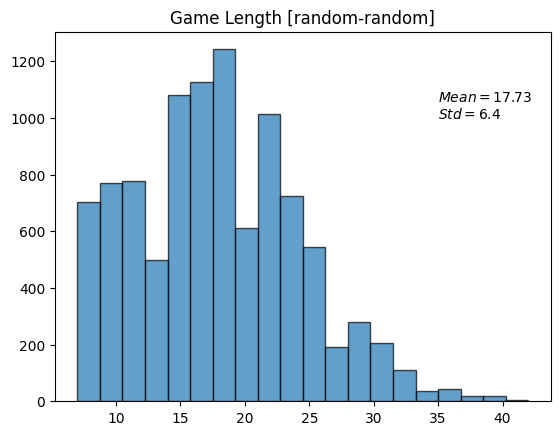

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42], dtype=int64)

In [16]:
row_count = dataset.groupby(level=0).size()

plt.hist(row_count, bins=20, alpha=0.7, edgecolor='black', linewidth=1)
plt.title('Game Length [random-random]')
plt.text(35, 1060, f'$Mean = {row_count.mean().round(2)}$')
plt.text(35, 1000, f'$Std = {row_count.std().round(2)}$')
plt.show()

np.sort(row_count.unique())

The mean and standard deviation of the distribution are definitely smaller than before: in this simulated dataset the games last less moves in average, and the consistency is higher.

In [17]:
first_move = dataset.groupby(dataset.index).first() # first row of each sequence (game)
last_move = dataset.groupby(dataset.index).last()   # last row of each sequence (game)
player_list = first_move['player'].unique()         # players' names

In [18]:
for player in player_list:
    print(f'{player} winrate = ', len(last_move[last_move['player'] == player]) / len(last_move))
print(f'Starter winrate  = ', len(first_move[first_move['player'] == last_move['player']]) / len(last_move))

SimpleAI_1 winrate =  0.9126
RandomAI_2 winrate =  0.0874
Starter winrate  =  0.5118


As you can see, just by implementing a very simple strategy we have obtained an incredible player when compared to the *random* one. If you want a more challenging game, try a game against *Simply*, the `SimplePlayer()` opponent.

In [19]:
play_game = Game(game_type='user-simple', verbose=True, pause=True, player1='John', player2='Simply')
play_game.play_game()

The WINNER is Simply, SimpleAI!!!
+----------------------------------------------------------------+
0  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
1  |     |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
2  |  O  |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
3  |  X  |     |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
4  |  X  |  X  |     |     |     |     |     |
   +-----+-----+-----+-----+-----+-----+-----+
5  |  X  |  X  |  O  |  O  |  O  |  O  |     |
   +-----+-----+-----+-----+-----+-----+-----+
      0     1     2     3     4     5     6     


Now it's time to get to the core of the project: training a Recurrent Neural Network to learn to play the game with a simulated dataset. We are going to use the dataset produced by two `SimplePlayer()` agents playing against each other.\
To make the Network learn a robust winning strategy, we want to train it using only the moves made by the winner of the game: the `prepare_dataset()` function takes care of exactly that.

In [1]:
from tools.game_tools import *

In [2]:
dataset = simulation(n=100, game_type='simple-simple', save_json=False)
if len(dataset.index.unique()) < 10_000:
    dataset = read_json('simulations/simulation_simple-simple_10000.json')

Simulating: 100%|███████████████| 100/100 [00:01<00:00, 87.78it/s]


Before transforming the dataset into a Tensorflow dataset, we have to fix the issue with the length difference between different games. We use sequences that are long just as the mean length of the simulated games.\
However, some of them are shorter and we cannot use different-sized sequences to create a Tensorflow dataset. Then, we need to implement __*0-padding*__, that is, manually filling the missing values with useless data, such as rows with an empty board and a fixed move: on an empty board, we suppose that the best choice is to put the token in column 0.\
For example, if a sequence is shorter by 3 elements, we then add 3 empty boards with the same choice (column 0) to the sequence itself\
\
We also batch this dataset in equally-sized batches, each of them corresponding to the last $n$ moves of a game.

In [3]:
dataset = df_to_tensor(dataset)

The `quickdraw_dataset()` function has the aim of quickdrawing the final dataset - to be used with the neural network - from the tensor created from the dataframe.

In [4]:
def quickdraw_dataset(dataset, batch_size=32, shuffle_buffer_size=None, cache=False):
    if cache:
        # cache the dataset
        dataset = dataset.cache()
    if shuffle_buffer_size:
        # shuffle the dataset's batches
        dataset = dataset.shuffle(shuffle_buffer_size)
    # batch the games into batches of length 32, meaning that each batch will contain 32 games
    dataset = dataset.batch(batch_size) 
    return dataset

In [5]:
dataset = quickdraw_dataset(dataset, shuffle_buffer_size=50)

Before proceeding with the RNN training, I would like to emphasise the data structure we have obtained.\
The final dataset is a tensor of size $N_{batches}$ where $N_{batches}$ is the total number of batches. Each of these batches contains $N_{games}$ board state sequences, each of them associated to the winning move made in the simulation (called *choice* in the previous dataset). Each of these sequences contains $N_{moves}$ last winning moves for each game (this quantity corresponds to the average duration of the matches in the entire dataset).\
Therefore, each feature's shape can be represented as follows:
<center>

$$shape = (N_{games}, N_{moves}, N_{columns} \times N_{rows})$$

In [6]:
# sequence of board states (for the 1st batch)
for features, targets in dataset.take(1):
    features = features.numpy()
print(features.shape)

(32, 21, 42)


In [7]:
# sequence of moves made on the previous group of board states
for features, targets in dataset.take(1):
    targets = targets.numpy()
print(targets.shape)

(32,)


Now it's time to split the dataset into a training set and a validation set. We don't need the test set since the final metric to evaluate the model's performance will be calculated from a number of simulated games between `RNNPlayer()` and `SimplePlayer()`.

In [8]:
dataset_size = dataset_size = len(list(dataset))

val_size = int(0.2 * dataset_size)
val_ds = dataset.take(val_size)
train_ds = dataset.skip(val_size)

In [10]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1D(64, kernel_size=3, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(7, activation='softmax')
    ])
    return model

model = create_model()
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', patience=15, restore_best_weights=True
)
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-2, clipnorm=1.)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(train_ds, epochs=10,
                    validation_data=val_ds,
                    callbacks=[early_stopping_cb])

Epoch 1/10
251/251 [==============================] - 5s 9ms/step - loss: 1.9296 - accuracy: 0.1916 - val_loss: 1.9002 - val_accuracy: 0.2198
Epoch 2/10
251/251 [==============================] - 2s 7ms/step - loss: 1.8439 - accuracy: 0.2539 - val_loss: 1.8650 - val_accuracy: 0.2455
Epoch 3/10
251/251 [==============================] - 2s 7ms/step - loss: 1.7783 - accuracy: 0.3016 - val_loss: 1.8309 - val_accuracy: 0.2747
Epoch 4/10
251/251 [==============================] - 2s 6ms/step - loss: 1.7153 - accuracy: 0.3333 - val_loss: 1.7977 - val_accuracy: 0.2939
Epoch 5/10
251/251 [==============================] - 2s 7ms/step - loss: 1.6540 - accuracy: 0.3656 - val_loss: 1.7664 - val_accuracy: 0.3115
Epoch 6/10
251/251 [==============================] - 2s 7ms/step - loss: 1.5999 - accuracy: 0.3851 - val_loss: 1.7378 - val_accuracy: 0.3201
Epoch 7/10
251/251 [==============================] - 2s 7ms/step - loss: 1.5456 - accuracy: 0.4130 - val_loss: 1.7152 - val_accuracy: 0.3402
Epoch 

<Figure size 500x300 with 0 Axes>

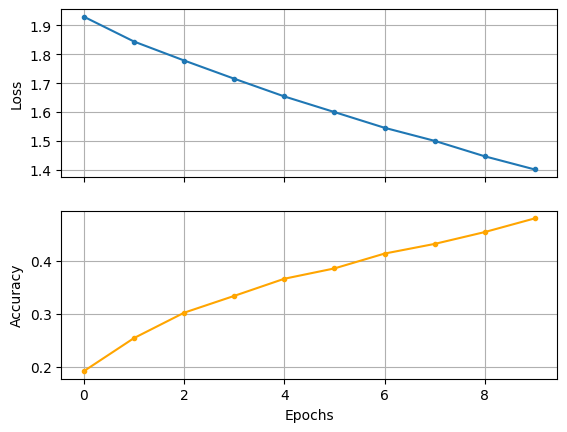

In [13]:
plt.figure(figsize=(5,3))
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(history.history['loss'], marker='.')
ax2.plot(history.history['accuracy'], marker='.', color='orange')

ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.xlabel('Epochs')
ax1.grid(True)
ax2.grid(True)

In [14]:
# unfortunately, we always have to pass an entire batch to the model predictor
# then, appending the desired sequence at the end of the batch, we can get the prediction's
# result by using index slicing on the numpy array
test = tf.convert_to_tensor(np.zeros(shape=(32, 11, 42)))
model.predict(test)[-1:].argmax()

1/1 [==============================] - 0s 481ms/step


6